## Exploratory Data Analysis For Stradle trading NFP and CPI on the BTC-USD exchange

In [1]:
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

`date`: in in yyyy-mm-dd format

`news_event`: Type of news event eg NFP or CPI

`news_in`: Market open price at 14:45 SAST

`news_fakeout`: Max price movement before news candle

`news_out`: The max movement from entry to end of news spike

`news_exit_time`: Time of max price fluctuation. Exit time for news trade, entry time for post-news trade

`rev_out`: Max Price achieved in post-news reversal

`rev_exit_time`: Time where "rev_out" value was recorded

In [2]:
df = pd.read_excel("raw_news_data.xlsx", engine="openpyxl")
df["date"] = pd.to_datetime(df["date"])
df["news_exit_time"] = pd.to_datetime(df["news_exit_time"], format="%H:%M:%S").dt.time
df["rev_exit_time"] = pd.to_datetime(df["rev_exit_time"], format="%H:%M:%S").dt.time
df["news_type"] = df.apply(lambda row: "sell" if row["news_in"] > row["news_out"] else "buy", axis=1)
df["rev_type"] = df.apply(lambda row: "sell" if row["news_out"] > row["rev_out"] else "buy", axis=1)
df.set_index("date", inplace=True)
df.head()

,news_event,news_in,news_fakeout,news_out,news_exit_time,rev_out,rev_exit_time,news_type,rev_type
date,,,,,,,,,
2025-02-12,cpi,96104,96572,94049,15:30:00,97647,19:30:00,sell,buy
2025-01-15,cpi,97005,96833,100831,18:00:00,98593,22:00:00,buy,sell
2024-12-11,cpi,98335,98068,100639,18:15:00,99664,20:00:00,buy,sell
2024-11-13,cpi,87956,87642,93427,18:00:00,88032,23:15:00,buy,sell
2024-10-10,cpi,60899,61200,58902,18:15:00,60719,03:45:00,sell,buy


## Preprocessing and Feature Engineering

In [3]:
#news price movement
df["news_movement_price"] = abs(df["news_in"] - df["news_out"])
df['news_movement_percent'] = (df["news_movement_price"] / df["news_in"]) * 100

#post news reversal price movement
df["reversal_movement_price"] = abs(df["news_out"] - df["rev_out"])
df['reversal_movement_percent'] = (df["reversal_movement_price"] / df["news_out"]) * 100

#Fakeout data
df["fakeout_size"] = abs(df["news_in"] - df["news_fakeout"])
df["fakeout_percent"] = (df["fakeout_size"] / df["news_in"]) * 100

#news duration
df["temp"] = pd.to_datetime(df.index.astype(str) + " " + df["news_exit_time"].astype(str))
reference_time = pd.to_datetime(df.index.astype(str) + " 14:45:00")
duration = df["temp"] - reference_time
df["news_duration"] = duration.apply(lambda x: f"{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}")

#reversal duration
df["rev_temp"] = pd.to_datetime(df.index.astype(str) + " " + df["rev_exit_time"].astype(str))
df["reversal_duration"] = (df["rev_temp"] - df["temp"]).apply(
    lambda x: f"{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}")

#format df
df.drop(columns=["temp", "rev_temp"], inplace=True)
df = df.sort_index().copy()
df["date_order"] = range(len(df))

df.head()

,news_event,news_in,news_fakeout,news_out,news_exit_time,rev_out,rev_exit_time,news_type,rev_type,news_movement_price,news_movement_percent,reversal_movement_price,reversal_movement_percent,fakeout_size,fakeout_percent,news_duration,reversal_duration,date_order
date,,,,,,,,,,,,,,,,,,
2023-11-03,nfp,34315,34307,34822,17:30:00,34314,19:45:00,buy,sell,507,1.477488,508,1.458848,8,0.023313,02:45:00,02:15:00,0
2023-11-14,cpi,36298,36667,34789,20:45:00,38630,01:30:00,sell,buy,1509,4.157254,3841,11.040846,369,1.016585,06:00:00,04:45:00,1
2023-12-08,nfp,43728,43464,44675,23:15:00,44077,01:45:00,buy,sell,947,2.165660,598,1.338556,264,0.603732,08:30:00,02:30:00,2
2023-12-13,cpi,41155,41093,42843,21:30:00,42566,22:15:00,buy,sell,1688,4.101567,277,0.646547,62,0.150650,06:45:00,00:45:00,3
2024-01-05,nfp,43204,44051,43071,19:00:00,44298,22:45:00,sell,buy,133,0.307842,1227,2.848785,847,1.960467,04:15:00,03:45:00,4


## Visualization
### 1. Bar charts
---
### Price movement visualization

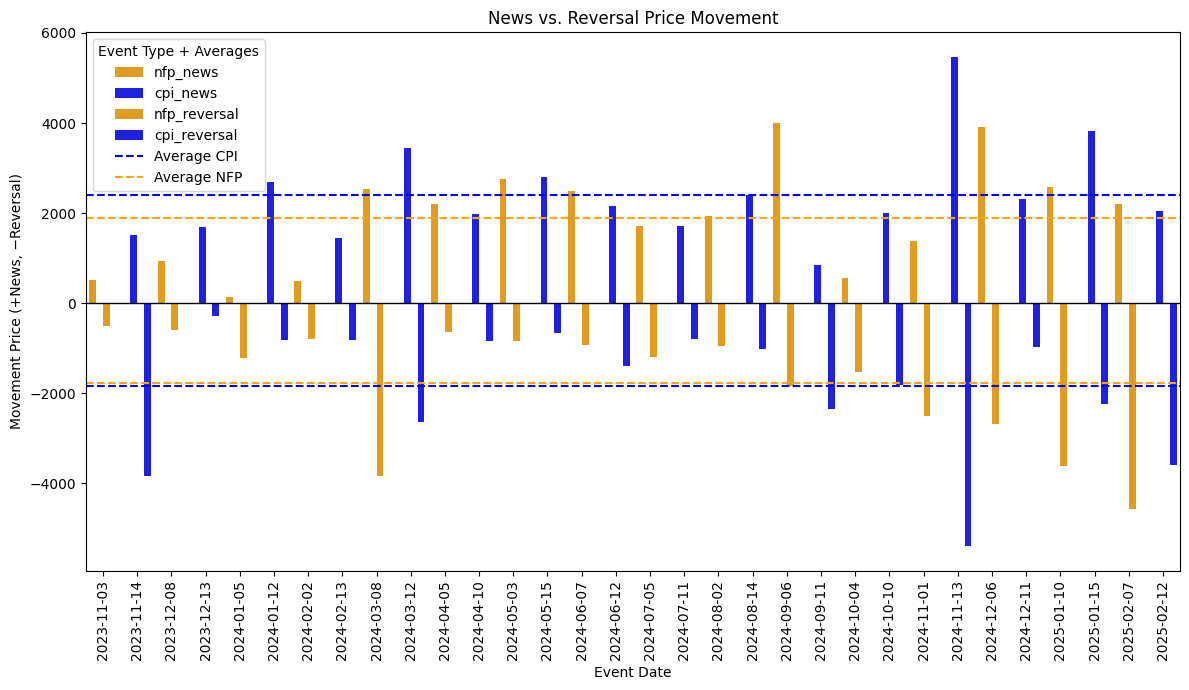

In [4]:
#reshape into a plotting df
df_reset = df.reset_index()
df_news = df_reset.copy()
df_news["movement"] = df_news["news_movement_price"]
df_news["event_movement_type"] = df_news["news_event"] + "_news"
df_rev = df_reset.copy()
df_rev["movement"] = -df_rev["reversal_movement_price"]
df_rev["event_movement_type"] = df_rev["news_event"] + "_reversal"
df_plot = pd.concat([df_news, df_rev], ignore_index=True)

#colors
custom_palette = {
    "cpi_news": "blue",
    "cpi_reversal": "blue",
    "nfp_news": "orange",
    "nfp_reversal": "orange"
}

#Bar Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_plot,
    x="date",
    y="movement",
    hue="event_movement_type",
    palette=custom_palette)

plt.axhline(y=0, color='black', linewidth=1)
plt.xticks(rotation=90, ha='center')
plt.title("News vs. Reversal Price Movement")
plt.xlabel("Event Date")
plt.ylabel("Movement Price (+News, −Reversal)")
plt.legend(title="Event Movement Type")

#news means
cpi_news_avg = df.loc[df["news_event"] == "cpi", "news_movement_price"].mean()
nfp_news_avg = df.loc[df["news_event"] == "nfp", "news_movement_price"].mean()
plt.axhline(y=cpi_news_avg, color='blue', linestyle='dashed', linewidth=1.5)
plt.axhline(y=nfp_news_avg, color='orange', linestyle='dashed', linewidth=1.5)
#reversal means
cpi_rev_avg = df.loc[df["news_event"] == "cpi", "reversal_movement_price"].mean()
nfp_rev_avg = df.loc[df["news_event"] == "nfp", "reversal_movement_price"].mean()
plt.axhline(y=(0-cpi_rev_avg), color='blue', linestyle='dashed', linewidth=1.5, label=f"Average CPI")
plt.axhline(y=(0-nfp_rev_avg), color='orange', linestyle='dashed', linewidth=1.5, label=f"Average NFP")
plt.legend(title="Event Type + Averages")
plt.tight_layout()
plt.show()

### Percentage movement of Price in News and Post-News Reversal

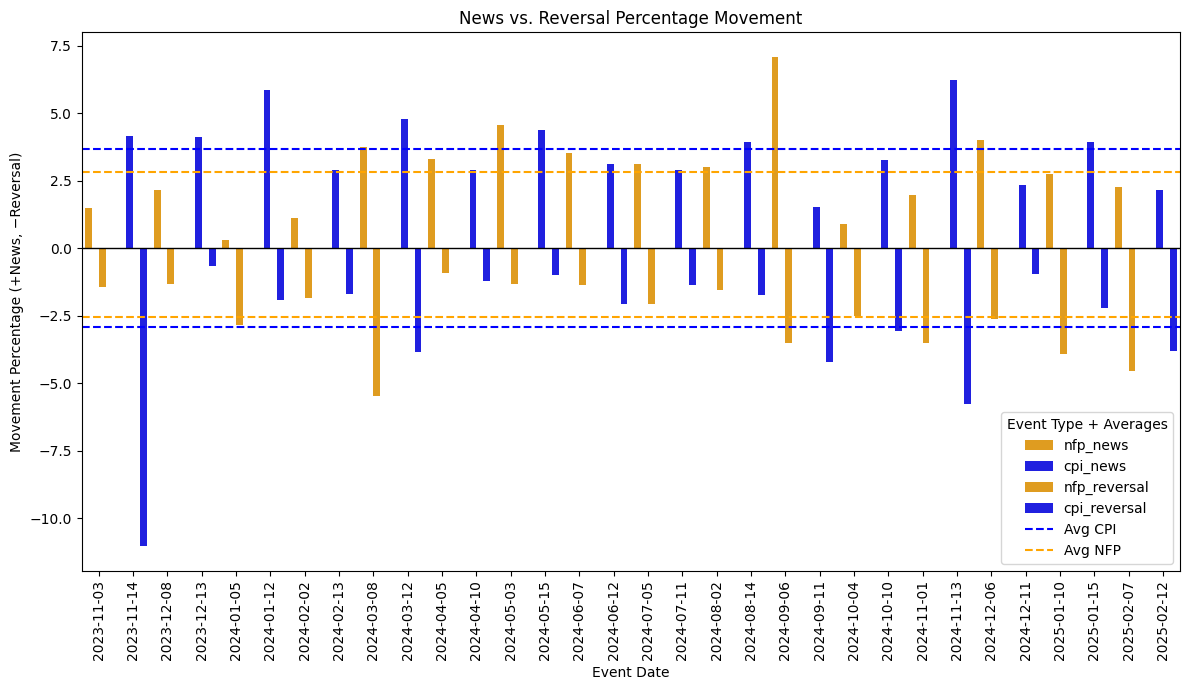

In [5]:
#reshape into a plotting df
df_reset = df.reset_index()
df_news = df_reset.copy()
df_news["movement"] = df_news["news_movement_percent"]
df_news["event_movement_type"] = df_news["news_event"] + "_news"
df_rev = df_reset.copy()
df_rev["movement"] = -df_rev["reversal_movement_percent"]
df_rev["event_movement_type"] = df_rev["news_event"] + "_reversal"
df_plot = pd.concat([df_news, df_rev], ignore_index=True)

# Define colors
custom_palette = {
    "cpi_news": "blue",
    "cpi_reversal": "blue",
    "nfp_news": "orange",
    "nfp_reversal": "orange"
}

#Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_plot,
    x="date",
    y="movement",
    hue="event_movement_type",
    palette=custom_palette
)


plt.axhline(y=0, color='black', linewidth=1)
plt.xticks(rotation=90, ha='center')
plt.title("News vs. Reversal Percentage Movement")
plt.xlabel("Event Date")
plt.ylabel("Movement Percentage (+News, −Reversal)")

# Calculate means for news and reversal percentages
cpi_news_avg = df.loc[df["news_event"] == "cpi", "news_movement_percent"].mean()
nfp_news_avg = df.loc[df["news_event"] == "nfp", "news_movement_percent"].mean()
cpi_rev_avg = df.loc[df["news_event"] == "cpi", "reversal_movement_percent"].mean()
nfp_rev_avg = df.loc[df["news_event"] == "nfp", "reversal_movement_percent"].mean()

# Add dashed lines for average news and reversal percentages
plt.axhline(y=cpi_news_avg,  color='blue',   linestyle='dashed', linewidth=1.5)
plt.axhline(y=nfp_news_avg,  color='orange', linestyle='dashed', linewidth=1.5)
plt.axhline(y=-cpi_rev_avg,  color='blue',   linestyle='dashed', linewidth=1.5, label="Avg CPI")
plt.axhline(y=-nfp_rev_avg,  color='orange', linestyle='dashed', linewidth=1.5, label="Avg NFP")
plt.legend(title="Event Type + Averages")

plt.tight_layout()
plt.show()

### Fakeout size in Dollar

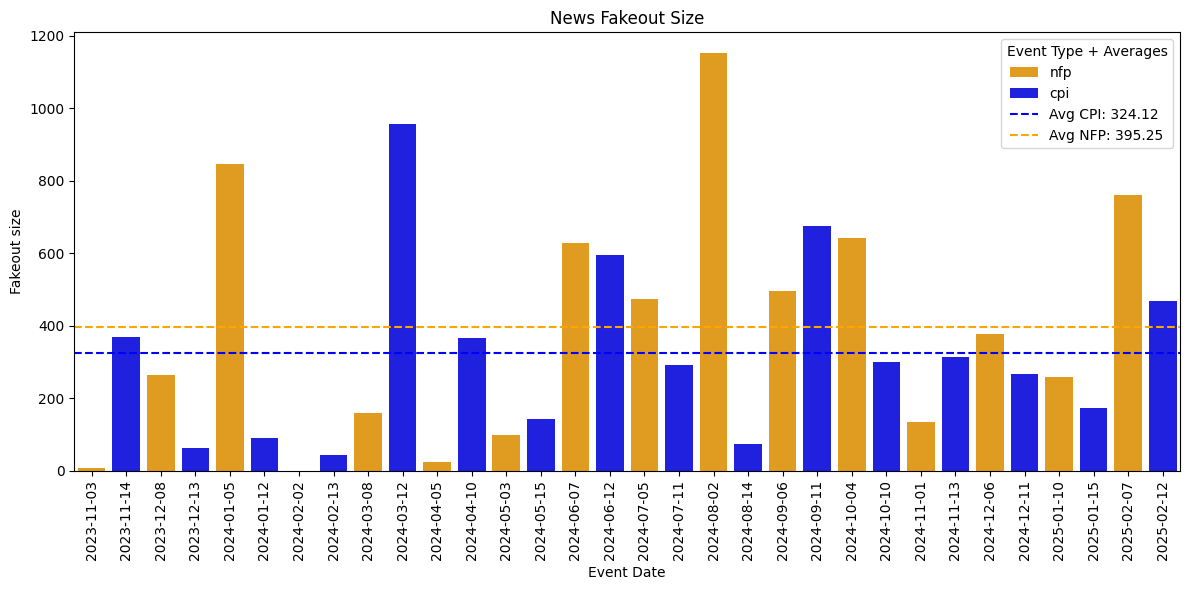

In [6]:
#color palette
custom_palette = {
    "cpi": "blue",
    "nfp": "orange"
}

cpi_avg_fakeout = df.loc[df["news_event"] == "cpi", "fakeout_size"].mean()
nfp_avg_fakeout = df.loc[df["news_event"] == "nfp", "fakeout_size"].mean()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df.reset_index(),
    x="date",
    y="fakeout_size",
    hue="news_event",
    palette=custom_palette
)

plt.title("News Fakeout Size")
plt.xlabel("Event Date")
plt.ylabel("Fakeout size")
plt.xticks(rotation=90, ha='center')

plt.axhline(y=cpi_avg_fakeout, color='blue',   linestyle='dashed', linewidth=1.5, label=f"Avg CPI: {cpi_avg_fakeout:.2f}")
plt.axhline(y=nfp_avg_fakeout, color='orange', linestyle='dashed', linewidth=1.5, label=f"Avg NFP: {nfp_avg_fakeout:.2f}")
plt.legend(title="Event Type + Averages")

plt.tight_layout()
plt.show()

### Fakeout Size as a Percentage of Price

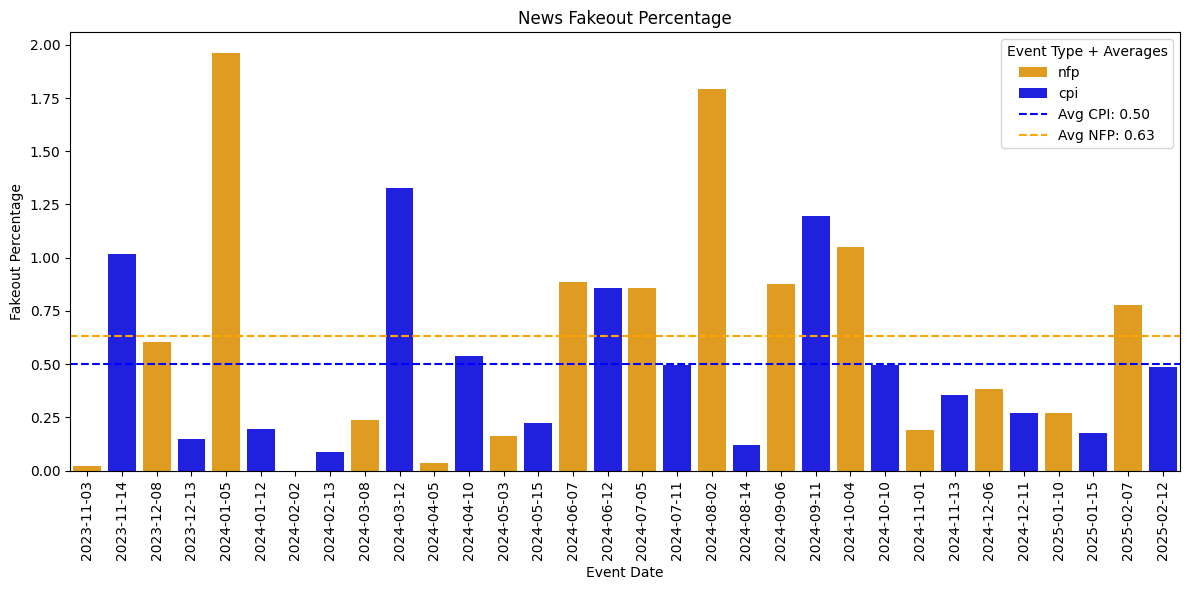

In [7]:
#color palette
custom_palette = {
    "cpi": "blue",
    "nfp": "orange"
}

cpi_avg_fakeout = df.loc[df["news_event"] == "cpi", "fakeout_percent"].mean()
nfp_avg_fakeout = df.loc[df["news_event"] == "nfp", "fakeout_percent"].mean()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df.reset_index(),
    x="date",
    y="fakeout_percent",
    hue="news_event",
    palette=custom_palette
)

plt.title("News Fakeout Percentage")
plt.xlabel("Event Date")
plt.ylabel("Fakeout Percentage")
plt.xticks(rotation=90, ha='center')

plt.axhline(y=cpi_avg_fakeout, color='blue',   linestyle='dashed', linewidth=1.5, label=f"Avg CPI: {cpi_avg_fakeout:.2f}")
plt.axhline(y=nfp_avg_fakeout, color='orange', linestyle='dashed', linewidth=1.5, label=f"Avg NFP: {nfp_avg_fakeout:.2f}")
plt.legend(title="Event Type + Averages")

plt.tight_layout()
plt.show()

### Duration of News and Post-News Reversal in Minutes

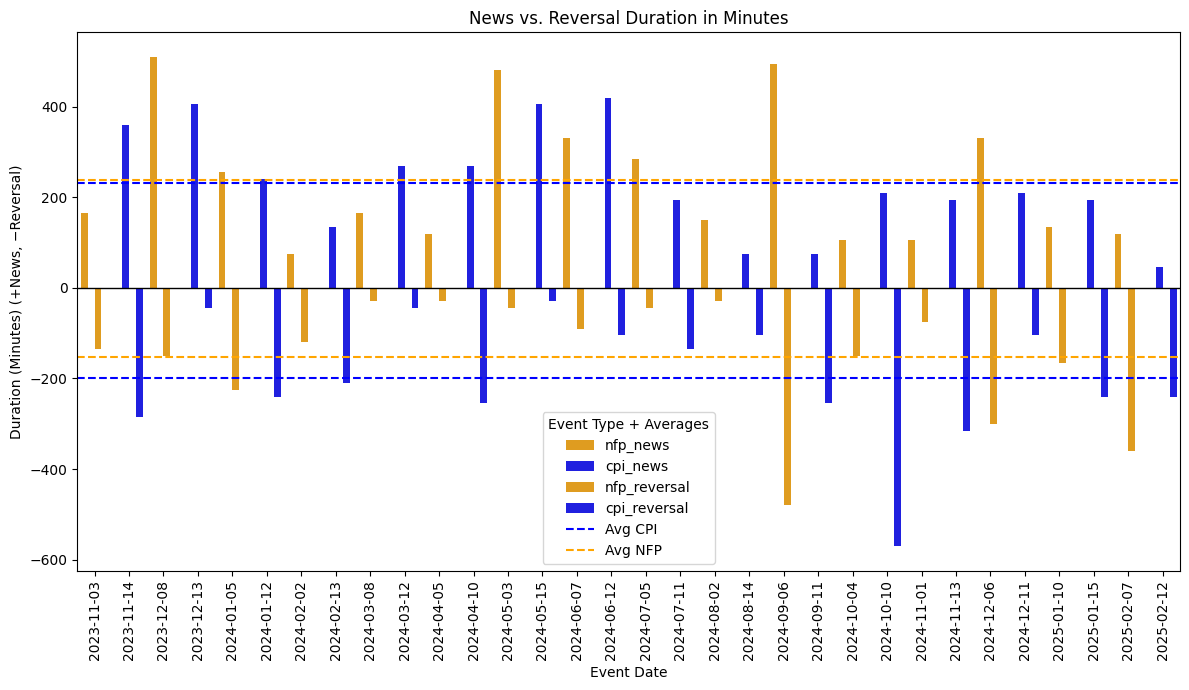

In [8]:
#convert durations to total minutes (float)
df["news_duration_minutes"] = pd.to_timedelta(df["news_duration"]).dt.total_seconds() / 60
df["reversal_duration_minutes"] = pd.to_timedelta(df["reversal_duration"]).dt.total_seconds() / 60

#create plotting df
df_reset = df.reset_index()  # If 'date' is the index, convert it into a column
df_news = df_reset.copy()
df_news["duration"] = df_news["news_duration_minutes"]  # positive
df_news["event_movement_type"] = df_news["news_event"] + "_news"
df_rev = df_reset.copy()
df_rev["duration"] = -df_rev["reversal_duration_minutes"]  # negative
df_rev["event_movement_type"] = df_rev["news_event"] + "_reversal"
df_plot = pd.concat([df_news, df_rev], ignore_index=True)

# Custom colour palette
custom_palette = {
    "cpi_news": "blue",
    "cpi_reversal": "blue",
    "nfp_news": "orange",
    "nfp_reversal": "orange"
}

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_plot,
    x="date",
    y="duration",
    hue="event_movement_type",
    palette=custom_palette
)
plt.axhline(y=0, color='black', linewidth=1)
plt.title("News vs. Reversal Duration in Minutes")
plt.xlabel("Event Date")
plt.ylabel("Duration (Minutes) (+News, −Reversal)")
plt.xticks(rotation=90, ha='center')
plt.legend(title="Event Movement Type")

# Calculate average durations in minutes
cpi_news_avg = df.loc[df["news_event"] == "cpi", "news_duration_minutes"].mean()
nfp_news_avg = df.loc[df["news_event"] == "nfp", "news_duration_minutes"].mean()
cpi_rev_avg = df.loc[df["news_event"] == "cpi", "reversal_duration_minutes"].mean()
nfp_rev_avg = df.loc[df["news_event"] == "nfp", "reversal_duration_minutes"].mean()

plt.axhline(y=cpi_news_avg,  color='blue',   linestyle='dashed', linewidth=1.5)
plt.axhline(y=nfp_news_avg,  color='orange', linestyle='dashed', linewidth=1.5)
plt.axhline(y=-cpi_rev_avg,  color='blue',   linestyle='dashed', linewidth=1.5, label="Avg CPI")
plt.axhline(y=-nfp_rev_avg,  color='orange', linestyle='dashed', linewidth=1.5, label="Avg NFP")
plt.legend(title="Event Type + Averages")

plt.tight_layout()
plt.show()

---
### 2. Probability Density Distributions

In [9]:
def density_distro_plot(name, str_id):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    # --- Left Subplot: CPI ---
    sns.histplot(
        data=df[df["news_event"] == "cpi"],
        x=str_id,
        bins=11,
        stat="density",
        color="blue",
        alpha=0.6,
        ax=axes[0])
    
    sns.kdeplot(
        data=df[df["news_event"] == "cpi"],
        x=str_id,
        color="blue",
        ax=axes[0])
    
    axes[0].set_title(f"CPI: Distribution of {str_id}")
    axes[0].set_xlabel(f"{name}")
    axes[0].set_ylabel("Count")
    
    # --- Right Subplot: NFP ---
    sns.histplot(
        data=df[df["news_event"] == "nfp"],
        x=str_id,
        bins=11,
        stat="density",
        color="orange",
        alpha=0.6,
        ax=axes[1])
    
    sns.kdeplot(
        data=df[df["news_event"] == "nfp"],
        x=str_id,
        color="orange",
        ax=axes[1])
    
    axes[1].set_title(f"NFP: Distribution of {str_id}")
    axes[1].set_xlabel(f"{name}")
    axes[1].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()
    
    # Compute the five-number summary for CPI and NFP
    cpi_summary = df[df["news_event"] == "cpi"][str_id].describe()
    nfp_summary = df[df["news_event"] == "nfp"][str_id].describe()
    
    # Extract the five key statistics
    cpi_five_point = {
        "Min": cpi_summary["min"],
        "Q1 (25%)": cpi_summary["25%"],
        "Median": cpi_summary["50%"],
        "Mean": df.loc[df["news_event"] == "cpi", str_id].mean(),
        "Q3 (75%)": cpi_summary["75%"],
        "Max": cpi_summary["max"]
    }
    nfp_five_point = {
        "Min": nfp_summary["min"],
        "Q1 (25%)": nfp_summary["25%"],
        "Median": nfp_summary["50%"],
        "Mean": df.loc[df["news_event"] == "nfp", str_id].mean(),
        "Q3 (75%)": nfp_summary["75%"],
        "Max": nfp_summary["max"]
    }
    
    print(f"📊 Five-Number Summary for CPI {name}:")
    for key, value in cpi_five_point.items():
        print(f"{key}: {value:.2f}")
    print(f"\n📊 Five-Number Summary for NFP {name}:")
    for key, value in nfp_five_point.items():
        print(f"{key}: {value:.2f}")

---
### News Price Movement Percentage Distribution

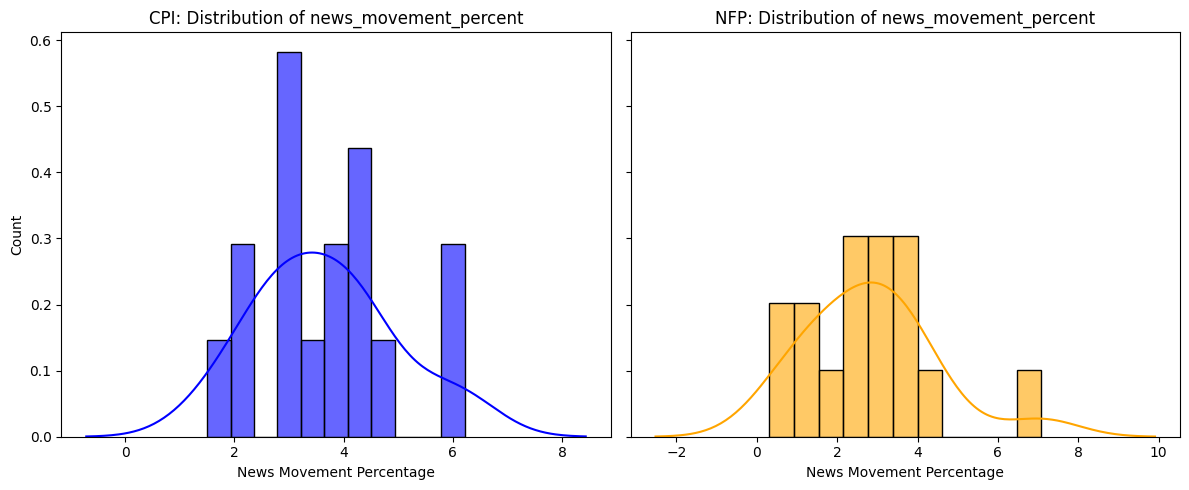

📊 Five-Number Summary for CPI News Movement Percentage:
Min: 1.50
Q1 (25%): 2.89
Median: 3.61
Mean: 3.65
Q3 (75%): 4.21
Max: 6.22

📊 Five-Number Summary for NFP News Movement Percentage:
Min: 0.31
Q1 (25%): 1.85
Median: 2.87
Mean: 2.83
Q3 (75%): 3.58
Max: 7.08


In [10]:
density_distro_plot("News Movement Percentage", "news_movement_percent")

---
### Post-News Reversal Price Movement Percentage Distribution

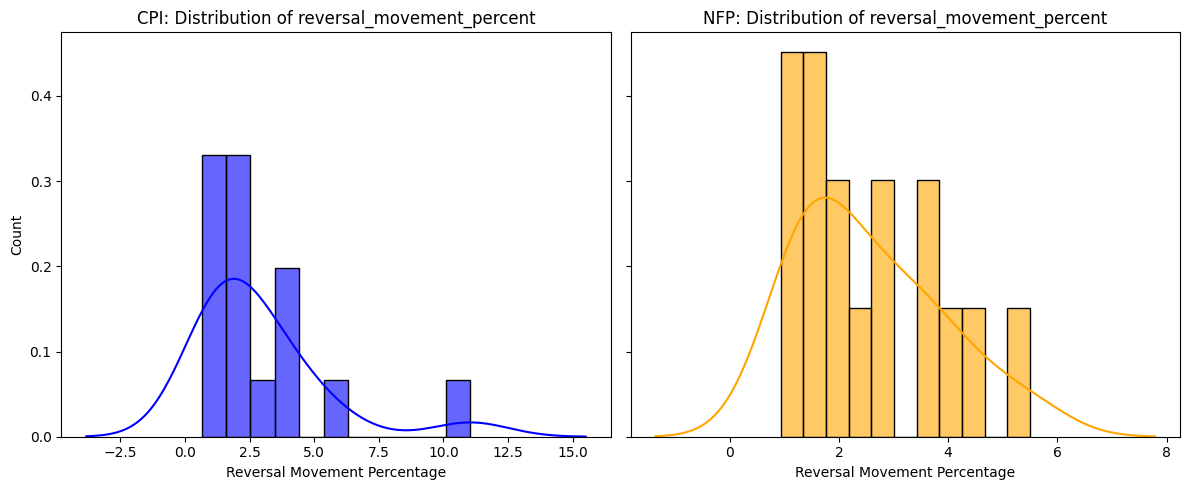

📊 Five-Number Summary for CPI Reversal Movement Percentage:
Min: 0.65
Q1 (25%): 1.33
Median: 1.99
Mean: 2.91
Q3 (75%): 3.83
Max: 11.04

📊 Five-Number Summary for NFP Reversal Movement Percentage:
Min: 0.93
Q1 (25%): 1.44
Median: 2.31
Mean: 2.56
Q3 (75%): 3.51
Max: 5.50


In [11]:
density_distro_plot("Reversal Movement Percentage", "reversal_movement_percent")

---
### Fakeout Price Movement Percentage Distribution

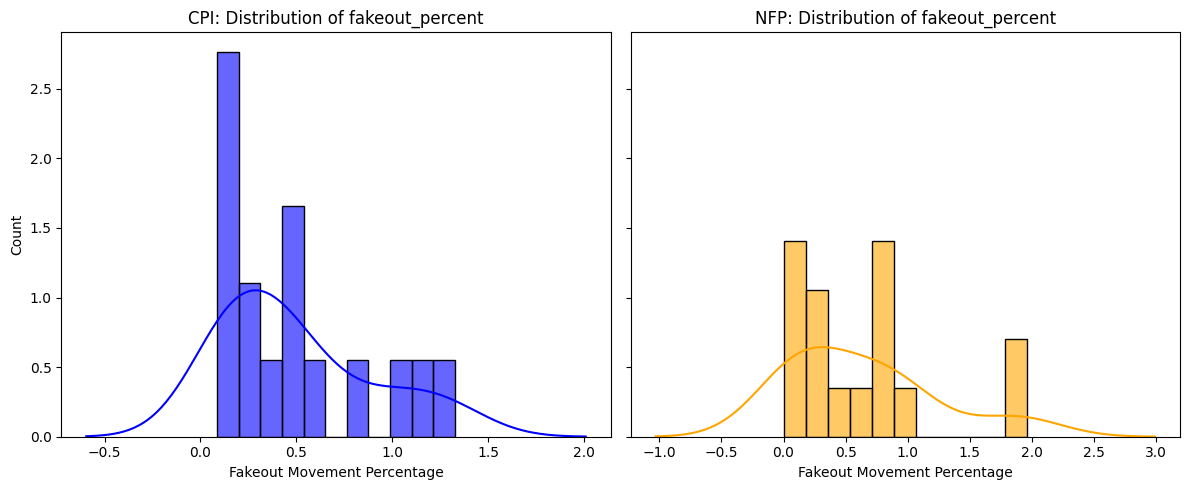

📊 Five-Number Summary for CPI Fakeout Movement Percentage:
Min: 0.09
Q1 (25%): 0.19
Median: 0.42
Mean: 0.50
Q3 (75%): 0.62
Max: 1.33

📊 Five-Number Summary for NFP Fakeout Movement Percentage:
Min: 0.00
Q1 (25%): 0.18
Median: 0.49
Mean: 0.63
Q3 (75%): 0.88
Max: 1.96


In [12]:
density_distro_plot("Fakeout Movement Percentage", "fakeout_percent")

---
### News Duration Distribution

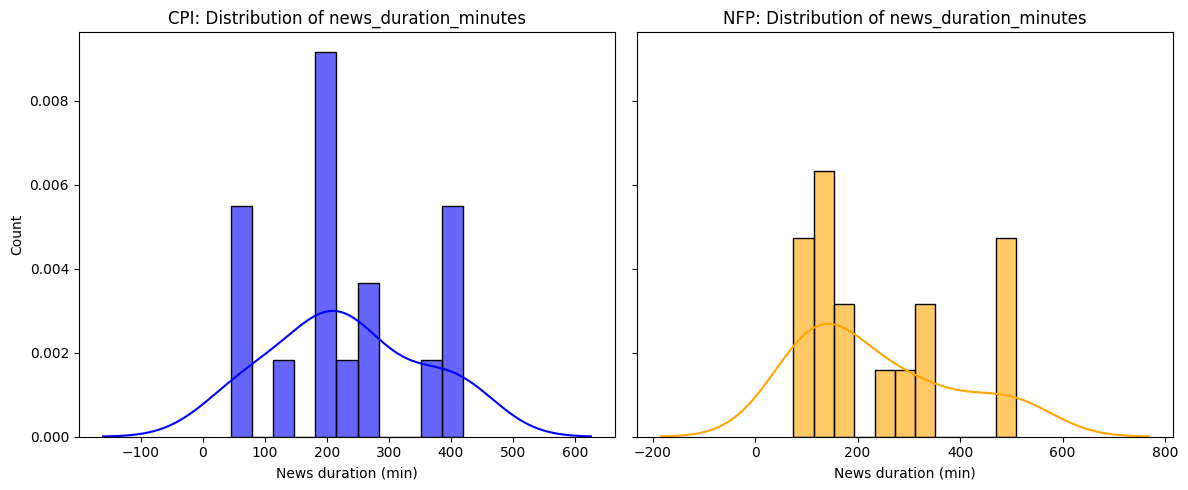

📊 Five-Number Summary for CPI News duration (min):
Min: 45.00
Q1 (25%): 180.00
Median: 210.00
Mean: 231.56
Q3 (75%): 292.50
Max: 420.00

📊 Five-Number Summary for NFP News duration (min):
Min: 75.00
Q1 (25%): 120.00
Median: 165.00
Mean: 239.06
Q3 (75%): 330.00
Max: 510.00


In [13]:
density_distro_plot("News duration (min)", "news_duration_minutes")

---
### Reversal Duration Distribution

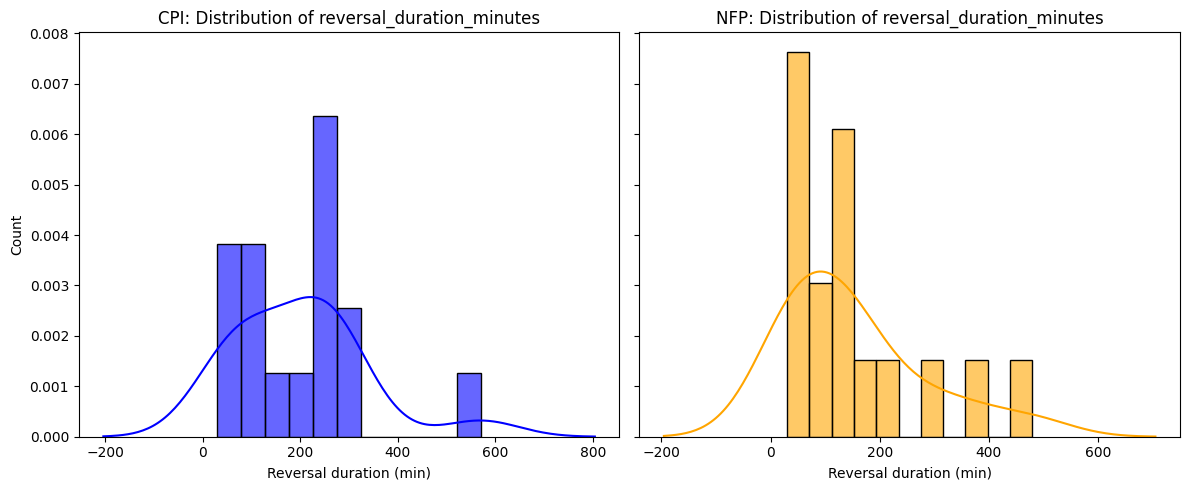

📊 Five-Number Summary for CPI Reversal duration (min):
Min: 30.00
Q1 (25%): 105.00
Median: 225.00
Mean: 198.75
Q3 (75%): 255.00
Max: 570.00

📊 Five-Number Summary for NFP Reversal duration (min):
Min: 30.00
Q1 (25%): 45.00
Median: 127.50
Mean: 151.88
Q3 (75%): 180.00
Max: 480.00


In [14]:
density_distro_plot("Reversal duration (min)", "reversal_duration_minutes")

# Profit and Drawback Calculations

In [15]:
df.head()

,news_event,news_in,news_fakeout,news_out,news_exit_time,rev_out,rev_exit_time,news_type,rev_type,news_movement_price,news_movement_percent,reversal_movement_price,reversal_movement_percent,fakeout_size,fakeout_percent,news_duration,reversal_duration,date_order,news_duration_minutes,reversal_duration_minutes
date,,,,,,,,,,,,,,,,,,,,
2023-11-03,nfp,34315,34307,34822,17:30:00,34314,19:45:00,buy,sell,507,1.477488,508,1.458848,8,0.023313,02:45:00,02:15:00,0,165.0,135.0
2023-11-14,cpi,36298,36667,34789,20:45:00,38630,01:30:00,sell,buy,1509,4.157254,3841,11.040846,369,1.016585,06:00:00,04:45:00,1,360.0,285.0
2023-12-08,nfp,43728,43464,44675,23:15:00,44077,01:45:00,buy,sell,947,2.165660,598,1.338556,264,0.603732,08:30:00,02:30:00,2,510.0,150.0
2023-12-13,cpi,41155,41093,42843,21:30:00,42566,22:15:00,buy,sell,1688,4.101567,277,0.646547,62,0.150650,06:45:00,00:45:00,3,405.0,45.0
2024-01-05,nfp,43204,44051,43071,19:00:00,44298,22:45:00,sell,buy,133,0.307842,1227,2.848785,847,1.960467,04:15:00,03:45:00,4,255.0,225.0


In [45]:
def compute_trade_result(row, SL_percentage):
    """
    Given one row and an SL_percent, return (trade_result, is_loss).
    is_loss=True only if "double stop" occurs.
    """
    news_in = row["news_in"]
    news_fakeout = row["news_fakeout"]
    news_movement_price = row["news_movement_price"]
    news_type = row["news_type"]  # "buy" or "sell"

    # Calculate the stop-loss amount in price terms
    SL_amount = news_in * (SL_percentage / 100.0)

    result = 0  # start at 0
    is_loss = False

    # 1) Check if the fakeout triggers a "double stop" (loss)
    if news_type == "buy":
        # Price dips below (news_in - SL_amount)
        if news_fakeout <= (news_in - SL_amount):
            result -= 2 * SL_amount
            is_loss = True
            return result, is_loss
    else:  # news_type == "sell"
        # Price spikes above (news_in + SL_amount)
        if news_fakeout >= (news_in + SL_amount):
            result -= 2 * SL_amount
            is_loss = True
            return result, is_loss

    # 2) Not stopped out by fakeout: subtract normal stop cost, then add movement
    result -= SL_amount
    result += news_movement_price

    return result, is_loss

def result(df, SL_percentage):
    """
    Loops over the entire df, computes:
      - Total P/L for CPI and NFP
      - Win Rate for CPI and NFP
    Returns (cpi_sum, nfp_sum, cpi_win_rate, nfp_win_rate).
    """
    cpi_sum = 0
    nfp_sum = 0
    cpi_losses = 0
    nfp_losses = 0

    # We assume you have 16 CPI rows and 16 NFP rows
    # but if your dataset changes, you can dynamically count them.
    cpi_total = (df["news_event"] == "cpi").sum()
    nfp_total = (df["news_event"] == "nfp").sum()

    for _, row in df.iterrows():
        trade_result, is_loss = compute_trade_result(row, SL_percentage)

        if row["news_event"] == "cpi":
            cpi_sum += trade_result
            if is_loss:
                cpi_losses += 1
        else:  # "nfp"
            nfp_sum += trade_result
            if is_loss:
                nfp_losses += 1

    # Calculate win rates
    # (Handle zero-division if you ever have no CPI or no NFP trades)
    cpi_win_rate = 1.0
    nfp_win_rate = 1.0
    
    if cpi_total > 0:
        cpi_win_rate = (cpi_total - cpi_losses) / cpi_total
    
    if nfp_total > 0:
        nfp_win_rate = (nfp_total - nfp_losses) / nfp_total

    return cpi_sum, nfp_sum, cpi_win_rate, nfp_win_rate

In [46]:
sl_values = []
cpi_values = []
nfp_values = []
cpi_win_rates = []
nfp_win_rates = []

sl_percent = 2.1
while sl_percent > 0:
    cpi_sum, nfp_sum, cpi_wr, nfp_wr = result(df, sl_percent)

    sl_values.append(sl_percent)
    cpi_values.append(cpi_sum)
    nfp_values.append(nfp_sum)
    cpi_win_rates.append(cpi_wr)
    nfp_win_rates.append(nfp_wr)

    sl_percent = round(sl_percent - 0.1, 2)  # step down by 0.1

# Build final DataFrame
results_df = pd.DataFrame({
    "cpi": cpi_values,
    "nfp": nfp_values,
    "cpi_win_rate": cpi_win_rates,
    "nfp_win_rate": nfp_win_rates
}, index=sl_values)

results_df.index.name = "SL_Percent"
results_df.head()

,cpi,nfp,cpi_win_rate,nfp_win_rate
SL_Percent,,,,
2.1,15995.932,8769.360,1.0,1.0000
2.0,17058.840,9797.200,1.0,1.0000
1.9,18121.748,9871.164,1.0,0.9375
1.8,19184.656,10942.208,1.0,0.9375
1.7,20247.564,8986.812,1.0,0.8750


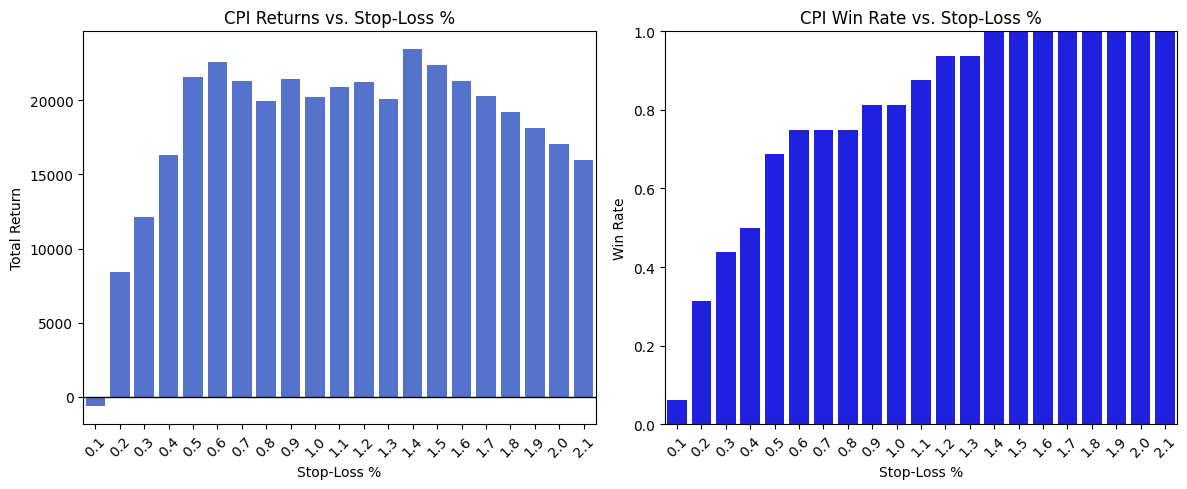

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left Subplot: CPI Returns ---
sns.barplot(
    x=results_df.index, 
    y=results_df["cpi"], 
    color="royalblue", 
    ax=axes[0]
)
axes[0].axhline(y=0, color='black', linewidth=1)
axes[0].set_title("CPI Returns vs. Stop-Loss %")
axes[0].set_xlabel("Stop-Loss %")
axes[0].set_ylabel("Total Return")
axes[0].tick_params(axis='x', rotation=45)

# --- Right Subplot: CPI Win Rate ---
sns.barplot(
    x=results_df.index, 
    y=results_df["cpi_win_rate"], 
    color="blue", 
    ax=axes[1]
)
axes[1].set_title("CPI Win Rate vs. Stop-Loss %")
axes[1].set_xlabel("Stop-Loss %")
axes[1].set_ylabel("Win Rate")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 1)  # Win rate is between 0 and 1

plt.tight_layout()
plt.show()

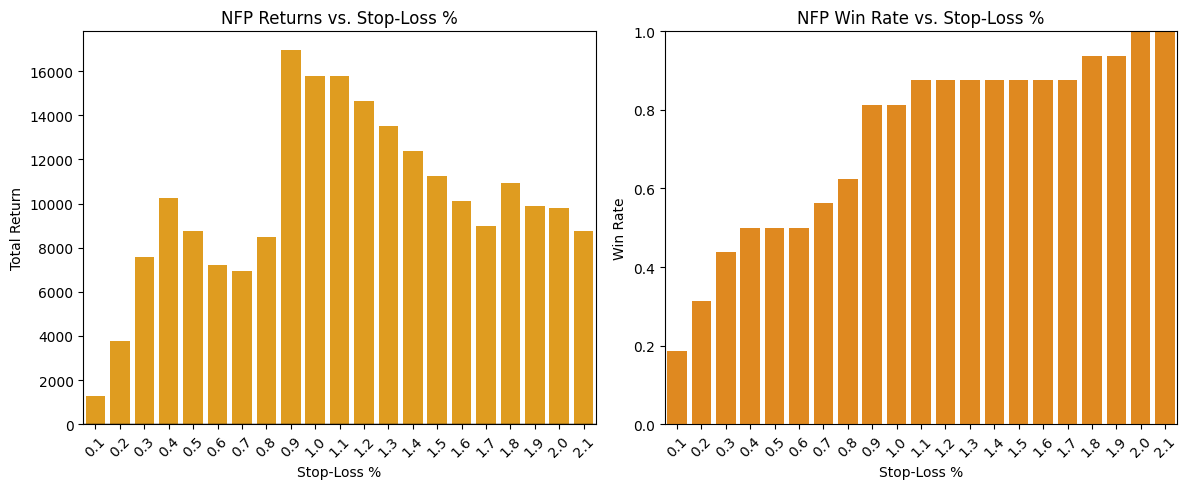

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left Subplot: NFP Returns ---
sns.barplot(
    x=results_df.index, 
    y=results_df["nfp"], 
    color="orange", 
    ax=axes[0]
)
axes[0].axhline(y=0, color='black', linewidth=1)
axes[0].set_title("NFP Returns vs. Stop-Loss %")
axes[0].set_xlabel("Stop-Loss %")
axes[0].set_ylabel("Total Return")
axes[0].tick_params(axis='x', rotation=45)

# --- Right Subplot: NFP Win Rate ---
sns.barplot(
    x=results_df.index, 
    y=results_df["nfp_win_rate"], 
    color="darkorange", 
    ax=axes[1]
)
axes[1].set_title("NFP Win Rate vs. Stop-Loss %")
axes[1].set_xlabel("Stop-Loss %")
axes[1].set_ylabel("Win Rate")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 1)  # Win rate is between 0 and 1

plt.tight_layout()
plt.show()